# Praca domowa 2
Autor: Paulina Przybyłek

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#import sysnp.count_nonzero
#!{sys.executable} -m pip install category_encoders
import category_encoders as ce

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('https://www.dropbox.com/s/360xhh2d9lnaek3/allegro-api-transactions.csv?dl=1')
data.head(5)

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki"


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420020 entries, 0 to 420019
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lp                      420020 non-null  int64  
 1   date                    420020 non-null  object 
 2   item_id                 420020 non-null  int64  
 3   categories              420020 non-null  object 
 4   pay_option_on_delivery  420020 non-null  int64  
 5   pay_option_transfer     420020 non-null  int64  
 6   seller                  420020 non-null  object 
 7   price                   420020 non-null  float64
 8   it_is_allegro_standard  420020 non-null  int64  
 9   it_quantity             420020 non-null  int64  
 10  it_is_brand_zone        420020 non-null  int64  
 11  it_seller_rating        420020 non-null  int64  
 12  it_location             420020 non-null  object 
 13  main_category           420020 non-null  object 
dtypes: float64(1), int64

In [4]:
#przyglądając się tej kolumnie uważam, że powinno się ją oczyścić - np. ujednolicić wielkość znaków
#jednak miast jest dużo, a my chcemy tylko sprawdzić działanie kodowania zmiennych, więc zrobimy jedynie powierzchowne czyszczenie
data.it_location = data.it_location.str.capitalize().str.lstrip()
data.it_location.head()

0               Warszawa
1               Warszawa
2                 Leszno
3    Wola krzysztoporska
4              Białystok
Name: it_location, dtype: object

Wczytana ramka danych ma 420020 rekordów, z czego w żadnej z 14 kolumn nie ma wartości brakującej (braku danych, NA). Mamy wartości typu ciągłego (9) oraz kategorycznego (5).

Praca domowa nie wymaga EDA wczytanej ramki danych, więc po krótkim przyjrzeniu się danych przechodzimy do celu pracy domowej.

# Kodowanie zmiennych kategorycznych

## Target Encoder

W przypadku kodowania metodą Target Encoding zmienna jest kodowana poprzez wyliczenie średniej z targetu dla danej kategorii. Wykonujemy go zgodnie z poleceniem - target ustawiamy na kolumnę price, a kodujemy zmienną it_location.

In [5]:
loc_counts = data.it_location.value_counts()
print(loc_counts)
print("Liczba miast występujących raz:", np.count_nonzero(loc_counts == 1))

Warszawa              27042
Kraków                16581
Łódź                  12433
Poznań                11197
Internet              10992
                      ...  
Czarny lasa               1
Nowa wies                 1
Plonsk                    1
Sobolew , garwolin        1
Opole wrocław             1
Name: it_location, Length: 7900, dtype: int64
Liczba miast występujących raz: 2342


Ustawiony target zawiera wartości typu float - ceny transakcji, a kodowana zmienna to miejscowości - wynika z nazw kolumn, a ich zawartości się z tym zgadzają. Mielibyśmy ok. 10 tysięcy wszystkich miast i ponad 3 tysiące miast, które występują tylko raz, jednak po oczyszczeniu danych ta liczba zmniejszyła się do 7900 miast i ponad 2 tysięcy, tych co występują tylko raz.

In [6]:
#funkcja wykorzystywana do kodowania zmiennych - posiada tylko potrzebne typy kodowania
def encoding(type_encoding : str, data_val : str, data_target = None):

    if(type_encoding == 'te'):
        en = ce.TargetEncoder(cols=[data_val], return_df=True)
    if(type_encoding == 'ohe'):
        en = ce.OneHotEncoder(cols=[data_val], use_cat_names=True, return_df=True)
    if(type_encoding == 'me'):
        en = ce.MEstimateEncoder(cols=[data_val], return_df=True)
    if(type_encoding == 'oe'):
        en = ce.OrdinalEncoder(cols=[data_val], return_df=True)
        
    data_en = data.copy()
    encoded = en.fit_transform(data_en, data_target)
    
    return encoded


In [7]:
data_te = encoding('te', 'it_location', data['price'])
data_te['orginal_it_location'] = data['it_location'] # nie jest to potrzebne, ale dodajemy dla porównania
data_te[['price', 'it_location', 'orginal_it_location']]

,price,it_location,orginal_it_location
0,59.99,84.132898,Warszawa
1,4.90,84.132898,Warszawa
2,109.90,64.883187,Leszno
3,18.50,35.433365,Wola krzysztoporska
4,19.90,73.772916,Białystok
...,...,...,...
420015,180.00,26.346402,Kraśnik
420016,14.99,63.645927,Dzierżoniów
420017,5.99,18.682800,Supraśl
420018,200.00,104.254805,Poznań


Nazwy miejscowości zostały zastąpione przez wyliczone wartości. Można sprawdzić czy średnie się zgadzają, my jednak sprawdzimy tylko jakie wartości zostały przypisane, gdy miejscowość wystąpiła raz.

In [8]:
row_number1 = data[data.it_location == 'Sajczyce'].iloc[0]['lp']
row_number2 = data[data.it_location == 'Bronisławów'].iloc[0]['lp']
data_tmp = data_te[(data.lp == row_number1) | (data.lp == row_number2)][['price', 'it_location']]
data_tmp

,price,it_location
367755,55.0,76.81135
399613,80.0,76.81135


In [9]:
data[(data.lp == row_number1) | (data.lp == row_number2)].groupby(['it_location'])['price'].mean()

it_location
Bronisławów    55.0
Sajczyce       80.0
Name: price, dtype: float64

In [10]:
#policzmy ile miast ma taką samą wartość co Sajczyce i Bronisław
mean = data_tmp.iloc[0]['it_location']
data_te[data_te.it_location == mean]['it_location'].count()

2342

Średnia wartość ceny dla tych miejscowości powinna być równa cenie z powodu jednego wystąpienia, jednak wartości nie zgadzają się. Jednak widzimy, że średnia jest taka sama dla obu miast, co może oznaczać, że target encoding policzył średnią wspólną dla miast występujących raz. Patrząc na to ile miast ma uzupełnioną średnią tą samą wartością co znalezione przez nas Sajczyce to mamy tyle miast, ile wystąpiło tylko raz. 

Czytając o target encoding nie spotkałam się (albo nie zauważyłam fragmentu o tym), że uzupełnia taką samą średnią wartości występujące raz, może być to niedokładość metody, błąd przy obliczaniu tego albo zbyt duża ilość miast spowodała taką niedokładność. Jest to ciekawe, czemu tak się dzieje, że wartości pojedyńcze są wrzucane do jednego wora i można by się na tym skupić, aby zobaczyć co jest nie tak (zagadnienie do zrobienia poza pracą domową).

Text(0.5, 1.0, 'Fragmenty rozkładów: red - price, blue - it_location')

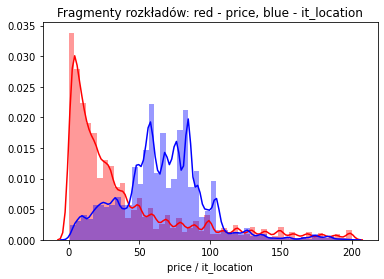

In [11]:
#sprawdźmy jak wyglądają rozkłady targetu i zakodowanych danych
pl = sns.distplot(data_te[data_te.price < 200]['price'], hist = True, color='red')
pl = sns.distplot(data_te[(data_te.price < 200) & (data_te.it_location < 200)]['it_location'], hist = True, color='blue')
pl.set_xlabel('price / it_location')
pl.set_title('Fragmenty rozkładów: red - price, blue - it_location')

Powyższy wykres należy rozumieć w ten sposób - na czerwono mamy fragment rozkładu price, a na niebiesko fragment rozkładu it_location, uzupełnionego średnią price dla kategorii. Wykorzystanie średniej całkowicie zmieniło wygląd rozkładu (oczywiście nadal mamy długie ogony w obu przypadkach, które zostały obcięte). Zamiast wysokiego piku na początku i długiego ogonu, mamy trochę lepiej rozłożony wykres.

Wykorzystywanie średniej może być przydatne do uczenia maszynowego. 

Wnioski:
 + target encoding uzupełnia kategorie średnią z targetu dla kategorii i nadpisuje kolumnę - nie tworzy to dodatkowych kolumn i nie zmienia wymiaru ramki (przewaga nad metodą one-hot encoding, która dla każdej kategorii tworzy oddzielną kolumnę - pamiętajmy, ze w tym przypadku stworzyłaby prawie 8 tysięcy nowych kolumn, dlatego nawet nie warto rozważać użycia tutaj tej metody)
 + wartości występujące raz otrzymały wspólną średnią - warto by się temu kiedyś przyjrzeć
 
Aby kodować lepiej zmienne powinniśmy oczyścić dane dokładniej, zrobilismy jedynie ujednolicenie wielkości znaków i usunęliśmy spacje za słowami. Możliwe, że są jakieś błędy w słowach, albo dziwne nazwy. Czyszczenie jednak byłoby mozolne i długie, aby sprawdzić wszystkie możliwe błędy, a dla danej pracy domowej, gdzie nie będziemy zajmować się uczeniem zbioru pozostawiamy to.

## One-hot encoding

Ten typ kodowania tworzy dla N zmiennych unikalnych w kolumnie N kolumn, zawierających 0 albo 1. Oznacza to, że każda zmienna ma odpowiadającą jej kolumnę określającą jej występowanie. Problematyczne jest to, że jeśli mamy wiele różnych zmiennych to powstanie nam wiele nowych kolumn do ramki danych, co wpływa źle na czas obliczeń jak i pamięć (wspomniano o tym poprzednio, mówiąc o przewadze target encoding nad OHE).

OHE zastosujemy dla kolumny main_category. 

In [12]:
print(data.main_category.value_counts().count())

27


Po zastosowaniu OHE powstanie nam 26 nowych kolumn (zastąpujemy main_category jedną z nich).

In [13]:
#można uzyskać to także metodą z pandasa pd.get_dummies(), ale my zastosujemy naszą funkcję
data_ohe = encoding('ohe', 'main_category')
data_ohe.iloc[:, np.r_[13:40]].head(10)

,main_category_Komputery,"main_category_Odzież, Obuwie, Dodatki",main_category_Dom i Ogród,main_category_Książki i Komiksy,main_category_Biżuteria i Zegarki,main_category_RTV i AGD,main_category_Motoryzacja,main_category_Dla Dzieci,main_category_Uroda,main_category_Telefony i Akcesoria,...,main_category_Filmy,main_category_Fotografia,main_category_Biuro i Reklama,main_category_Instrumenty,main_category_Muzyka,main_category_Konsole i automaty,"main_category_Sprzęt estradowy, studyjny i DJ-ski",main_category_Antyki i Sztuka,main_category_Bilety,main_category_Nieruchomości
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420020 entries, 0 to 420019
Data columns (total 40 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   lp                                                 420020 non-null  int64  
 1   date                                               420020 non-null  object 
 2   item_id                                            420020 non-null  int64  
 3   categories                                         420020 non-null  object 
 4   pay_option_on_delivery                             420020 non-null  int64  
 5   pay_option_transfer                                420020 non-null  int64  
 6   seller                                             420020 non-null  object 
 7   price                                              420020 non-null  float64
 8   it_is_allegro_standard                             420020 non-null  int64 

Po encodingu mamy zwiększony rozmiar danych, nieprzyjazna metoda dla wielu kategorii. Komentarz: oczywiście możemy nie nadpisywać kolumny, którą kodujemy, wymaga to zmiany w zapisie metody - ja dla wszstkich metod zastosowałam nadpisanie, ale nie jest to konieczność, czasem dla porównania lepiej zostawić kolumnę kodowaną.  

Podsumowanie:
+ dobre dla małej liczby kategorii, złe dla dużej liczby kategorii
+ zmienia wymiar danych i trzeba o tym pamiętać

## Ordinal Encoder

Kodowanie porządkowe koduje cechy kategoryczne na liczby porządkowe. W porównaniu do OHE powstanie jedna kolumna, ktora wartości string zamieni na int. Nie podając żadnych dodatkowych parametrów, liczby zostaną przyporządkowane do kategorii losowo. Sprawdźmy jak to wygląda w praktyce na naszej kolumnie main_category.

In [15]:
data_oe = encoding('oe', 'main_category')
data_oe['orginal_main_category'] = data['main_category'] #dodajemy kolumnę dla porównania
data_oe[['main_category', 'orginal_main_category']]

,main_category,orginal_main_category
0,1,Komputery
1,2,"Odzież, Obuwie, Dodatki"
2,3,Dom i Ogród
3,4,Książki i Komiksy
4,2,"Odzież, Obuwie, Dodatki"
...,...,...
420015,6,RTV i AGD
420016,9,Uroda
420017,2,"Odzież, Obuwie, Dodatki"
420018,8,Dla Dzieci


Kategorii mamy 27, więc nadpisana kolumna zawiera liczby od 1 do 27, po wykonaniu takiej metody warto zapisać sobie co oznaczają dane liczby. Przykład zastosowany to kodowanie domyślne, oczywiście można użyć mapowania, aby każda kategoria miała dopisaną wartość jaką chcemy. 

Wydaje mi się, że ta metoda może powodować problemy przy niektórych metodach uczenia maszynowego. 

Podsumowanie:
+ nie zmienia się rozmiar ramki danych - zastąpienie liczbami porządkowymi nadpisuje kolumnę kodowaną
+ kodowanie używa losowych wartości zmiennych, nie określa to żadnych relacji czy odległości między zmiennymi, trzeba to mieć na uwadze przy niektórych modelach uczenia maszynowego
+ mozna użyć własnego mapowania
+ najlepiej używać do uporządkowanych kategorii
+ jeśli wartość nie jest w zestawie danych przy testowaniu może zwracać -1, błąd albo wartość nan (nie sprawdzane informacje, napisane jako komentarz do metody i na przyszłość dla siebie do własnych obliczeń)

## M-estimate Encoder

Jest to uproszczona wersja Target Encoder, zawiera tylko jeden zmienny parametr (m) w przeciwieństwie do target endocing, gdzie są takie dwa (min_samples_leaf i smoothing). Wykorzystamy go dla kolumny main_category jak poprzednie dwie, jednak dodatkowo musimy dołożyć target, więc użyjemy kolumny price.

In [16]:
data_me = encoding('me', 'main_category', data['price'])
data_me[['price', 'main_category']]

,price,main_category
0,59.99,121.806959
1,4.90,75.858066
2,109.90,72.434802
3,18.50,25.031971
4,19.90,75.858066
...,...,...
420015,180.00,107.532762
420016,14.99,28.130309
420017,5.99,75.858066
420018,200.00,71.206519


Metoda pomyślnie zastąpiła wartości w kolumnie main_category. Wymiar danych się nie zmienił. Porównajmy wyniki M-Estimate Endodera z Target Encoderem:

### Dodatek: Target Encoder dla main_category

Zastosujemy ten typ kodowania ponownie, jednak tym razem użyjemy go na kolumnie main_category. Celem jest możliwość porównania tego sposobu z powyższym.

In [17]:
data_te = encoding('te', 'main_category', data['price'])
data_te[['price', 'main_category']]

,price,main_category
0,59.99,121.810064
1,4.90,75.858049
2,109.90,72.434754
3,18.50,25.027497
4,19.90,75.858049
...,...,...
420015,180.00,107.534272
420016,14.99,28.128577
420017,5.99,75.858049
420018,200.00,71.206386


In [18]:
data_tmp = data_te.copy()
data_tmp['main_category_ME'] = data_me['main_category']
data_tmp=data_tmp.rename(columns={"main_category":"main_category_TE"})
data_tmp['ME-TE'] = data_tmp['main_category_ME'] - data_tmp['main_category_TE']
data_tmp[['main_category_TE', 'main_category_ME', 'ME-TE']]

,main_category_TE,main_category_ME,ME-TE
0,121.810064,121.806959,-0.003105
1,75.858049,75.858066,0.000018
2,72.434754,72.434802,0.000048
3,25.027497,25.031971,0.004475
4,75.858049,75.858066,0.000018
...,...,...,...
420015,107.534272,107.532762,-0.001510
420016,28.128577,28.130309,0.001733
420017,75.858049,75.858066,0.000018
420018,71.206386,71.206519,0.000133


Jak widać w kolumnie ME-TE różnice w obliczanych wartościach są minimalne, jednak występują (choć chyba powinny, skoro mamy dwie inne metody, chyba, że ME byłby tylko uproszczony pod względem zapisanego kodu metody). 

Czy wpływa to na jakieś różnice wykresu rozkładu?

In [19]:
data_tmp['ME-TE'].describe()

count    420020.000000
mean          0.000101
std           0.013442
min          -0.135676
25%          -0.000667
50%           0.000048
75%           0.000133
max           4.881638
Name: ME-TE, dtype: float64

Maksymalna różnica wynosi niecałe 5, jednak w większości jest to niezauważalnie mała róznica, więc wykresy byłyby bardzo podobne.

Podsumowanie:
+ M-Estimate Encoder jest uproszczeniem Target Encodera
+ różnice w uzupełnianych wartościach między tymi dwiema metodami są minimalne
+ nie zmienia się wymiar danych

ME określane jest jako metoda "M-probability estimate of likelihood."

# Uzupełnianie braków

Kolumna price bedzie zmienną objaśniającą, a my ograniczamy się jedynie do zmiennych numerycznych - dokładniej trzech kolumn wybranych już poniżej. Nasz ramka danych nie ma braków danych, dlatego losowo usuniemy 10% z nich i zastąpimy przy użyciu technik imputacji.

W pierwszej części tego zadania usuniemy 10% z kolumny ***it_seller_rating***, a w drugiej oprócz it_seller_rating usuniemy też z kolumny ***it_quantity***. Eksperyment zostanie powtórzony 10 razy, a wyniki przedstawione w postaci opisów jak i wykresów.

In [20]:
data_actual = data.copy()
data_actual = data_actual.loc[:, ['price', 'it_seller_rating', 'it_quantity']]
data_actual.head(10)

,price,it_seller_rating,it_quantity
0,59.99,50177,997
1,4.90,12428,9288
2,109.90,7389,895
3,18.50,15006,971
4,19.90,32975,950
5,10.99,39371,742
6,10.99,39371,742
7,28.99,4287,886
8,12.00,5403,49
9,45.00,15561,4


Ramka danych data_actual to nasze przygotowane dane do zadania a poniżej mamy funkcje napisane dla uproszczenia obliczeń.

In [21]:
def rmse(data_actual : pd.DataFrame, data_predicted : pd.DataFrame):
    
    # funkcja licząca miarę RMSE dla imputacji braków danych
    
    rmse = np.sqrt(mean_squared_error(data_actual, data_predicted))
    
    return rmse
    
# tworzymy sobie funkcję tylko pod nasze zadanie, tzn. usuwa 10% danych z odpowiednich kolumn oraz imputuje je
# zwraca miary RMSE dla powtórzonego 10 razy algorytmu
# funkcja jest nieprzydatna nigdzie indziej - gdyż nie podajemy jej żadnych argumentów
# jednak możemy podać jeden argument wpływający na typ zadania do obliczeń
# jeśli True to liczymy dla drugiej części zadania
def RMSE(task_type_2 = False):
    
    # zwraca listę miar RMSE dla imputacji braków danych naszego zadania
    
    row_percent = len(data_actual) // 10     # 10 procent wierszy
    imp = IterativeImputer(max_iter=10)
    rnd = np.random.RandomState(123)      # ustawiamy jądro
    RMSE=[]                               # będziemy zwracać listę miar RMSE
    
    for i in range(10):
        chosen_idx1 = rnd.choice(len(data_actual), replace = False, size = row_percent) # wybieramy losowo indeksy
        data_imputed = data_actual.copy()
        data_imputed.loc[chosen_idx1, 'it_seller_rating'] = np.nan # uzupełniamy wartością nan
        if(task_type_2):
            chosen_idx2 = rnd.choice(len(data_actual), replace = False, size = row_percent)
            data_imputed.loc[chosen_idx2, 'it_quantity'] = np.nan
        data_imputed = pd.DataFrame(imp.fit_transform(data_imputed))
        RMSE.append(rmse(data_actual, data_imputed))
    
    return RMSE

## Część pierwsza: imputacja braków danych w kolumnie it_seller_rating

Zastąpimy 10% wierszy z kolumny it_seller_rating wartościami NaN, a następnie uzupełnimy je techniką ***Multivariate feature imputation***.

In [22]:
RMSE_cz1 = RMSE()
print('Średnie RMSE wyniku wynosi: ', round(np.mean(RMSE_cz1)))
print('Odchylenie standardowe wyniku miary RMSE wynosi: ', round(np.std(RMSE_cz1)))

Średnie RMSE wyniku wynosi:  6718.0
Odchylenie standardowe wyniku miary RMSE wynosi:  30.0


In [23]:
data_actual['it_seller_rating'].describe()

count    420020.000000
mean      20402.593496
std       36682.898636
min          -1.000000
25%        1581.000000
50%        6711.000000
75%       21007.000000
max      292074.000000
Name: it_seller_rating, dtype: float64

Patrząc na rozkład zmiennej ***it_seller_rating*** a wartości przyjęte przez miarę RMSE to odchylenie standardowe jest raczej niskie/małe, jednak średnia już niekoniecznie.

Jednak skoro odchylenie standardowe jest w porządku to można uznać, że imputacja braków przebiegła dobrze.

## Część druga: imputacja braków danych w kolumnie it_seller_rating oraz it_quantity

Analogiczne zadanie jak powyżej. Zastąpimy 10% wierszy z kolumny it_seller_rating oraz it_quantity wartościami NaN, a następnie uzupełnimy je taką samą techniką, czyli ***Multivariate feature imputation***.

In [24]:
RMSE_cz2 = RMSE(True)
print('Średnie RMSE wyniku wynosi: ', round(np.mean(RMSE_cz2)))
print('Odchylenie standardowe wyniku miary RMSE wynosi: ', round(np.std(RMSE_cz2)))

Średnie RMSE wyniku wynosi:  7957.0
Odchylenie standardowe wyniku miary RMSE wynosi:  39.0


Na początek trzeba zauważyć, że mamy ustawione jądro dla losowego wyszukiwania indeksów. Stąd może wyniki obu zadań są zbliżone - przynajmniej odchylenia standardowego. Trudno jednak oceniać miarę RMSE jako dobrą czy złą, ale średnia wzrosła o tysiąc, co świadczy o pogorszeniu jakości imputacji. Oznacza to, że przy większej ilości braków danych trudniej imputować poprawnie wartości.

Odchylenie standardowe nadal pozostaje małe (przynajmniej tak myślę), więc nadal nie jest to zła imputacja. Prawdopodobnie przy większej liczbie braków danych uległa by pogorszeniu bardziej.

## Wizualizacja wyników i ich podsumowanie

Text(0.5, 1.0, 'Miara RMSE w 10 iteracjach dla imputacji braków danych')

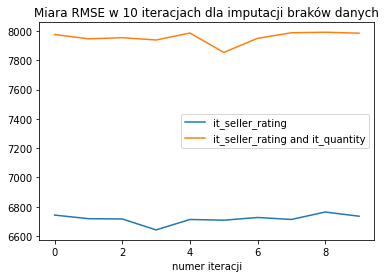

In [25]:
data_rmse = pd.DataFrame({'it_seller_rating': RMSE_cz1, 'it_seller_rating and it_quantity': RMSE_cz2})
pl = data_rmse.plot()
pl.set_xlabel('numer iteracji')
pl.set_title('Miara RMSE w 10 iteracjach dla imputacji braków danych')

Jak już zostało wspomniane, dla większej ilości danych imputacja ma gorszą jakość, na wykresie możemy zauważyć jak się to zmieniło dla 10 iteracji i usuwanych braków w jednej lub dwóch kolumnach. Skok jest spory, a usunęliśmy 10% danych, przy większej liczbie byłby pewnie jeszcze większy skok. Linie się nawet nie przecinają, a trwają w tym odstępie.